<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Pipeline containing data filtering and outlier detection</strong>
</div>

In [11]:
import os
import sys
sys.path.append(os.path.abspath(".."))
from db.__init__ import LOCAL_CONNECTION_URI

from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker

import pandas as pd
import geopandas as gpd
import numpy as np
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from data_pipeline.EntryDataCleaning import EntryDataCleaning

In [2]:
engine = create_engine(LOCAL_CONNECTION_URI)
Session = sessionmaker(bind=engine)

In [3]:
def get_all_offers() -> pd.DataFrame:
    Q_GET_OFFERS = """
    SELECT *
    FROM offers;
    """    
    with Session() as session:
        res = session.execute(text(Q_GET_OFFERS))
        df = pd.DataFrame(res.fetchall())
        df.index = df["id"]
        df.drop("id", axis=1, inplace=True)
        df = df.replace("-1", np.nan)
        return df

In [8]:
dcleaning = EntryDataCleaning()
df = dcleaning.run(get_all_offers())

In [ ]:
df.head()

,url_id,price,area,rooms,floor,floor_num,construction_status,ownership,build_year,balcony,...,lift,garage,market,offer_type,city,voivodeship,longitude,latitude,created_at,modified_at
id,,,,,,,,,,,,,,,,,,,,,
229246,431834,518600,65.00,4,3,<NA>,to_completion,full_ownership,<NA>,1,...,1,1,primary,mieszkanie,Gdańsk,pomorskie,18.616291,54.323699,2024-11-04 11:08:42+00:00,2024-11-06 11:09:42+00:00
229247,431621,1055274,63.09,3,5,7,to_completion,full_ownership,2025,1,...,1,1,primary,mieszkanie,Kraków,małopolskie,19.971010,50.048850,2024-10-31 12:17:55+00:00,2024-10-31 12:18:44+00:00
229248,430425,380900,27.50,1,9,10,to_completion,full_ownership,2024,1,...,1,1,primary,mieszkanie,Wrocław,dolnośląskie,16.996721,51.130219,2024-08-19 21:10:29+00:00,2024-11-03 20:23:41+00:00
229249,430286,660000,57.16,3,3,3,ready_to_use,full_ownership,2019,1,...,1,1,secondary,mieszkanie,Oleśnica,dolnośląskie,17.369884,51.213810,2024-11-03 12:04:26+00:00,2024-11-03 12:33:12+00:00
229250,431547,1150000,42.61,2,0,10,ready_to_use,full_ownership,2023,0,...,0,1,secondary,mieszkanie,Kraków,małopolskie,19.976430,50.055932,2024-11-03 11:35:43+00:00,2024-11-04 07:47:48+00:00


<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Visualization tool, helping decide the outliers bounds</strong>
</div>

In [6]:
def plot_outlier_methods(data: pd.DataFrame, col: str, bounds: tuple = None, iscont: bool = False) -> None:
    def minmax(filtered_col: pd.Series) -> tuple:
        fmin = filtered_col.min()
        fmax = filtered_col.max()
        return (fmin, fmax)

    def zscore_plot(data: pd.DataFrame, column: str, ax, color: str, title: str = "title") -> tuple:
        d = data.copy()
        d["zscore"] = zscore(d[column])
        filtered_z = d[abs(d["zscore"]) < 3]
        filtered_range_z = minmax(filtered_z[column])
        customhist(ax, filtered_z[column], filtered_range_z, color, title)
        return filtered_range_z

    def iqr_plot(data: pd.DataFrame, column: str, ax, color: str, title: str = "title") -> tuple:
        d = data.copy()
        Q1 = np.quantile(d[column], 0.25)
        Q3 = np.quantile(d[column], 0.75)
        IQR = Q3 - Q1
        filtered_iqr = d[d[column].between(Q1-1.5*IQR, Q3+1.5*IQR)]
        filtered_range_iqr = minmax(filtered_iqr[column])
        customhist(ax, filtered_iqr[column], filtered_range_iqr, color, title)
        return filtered_range_iqr

    def trim_plot(data: pd.DataFrame, column: str, ax, color: str, title: str = "title") -> tuple:
        d = data.copy()
        q001 = np.quantile(d[column], 0.01)
        q099 = np.quantile(d[column], 0.99)
        filtered_t = d[d[column].between(q001, q099)]
        filtered_range_t = minmax(filtered_t[column])
        customhist(ax, filtered_t[column], filtered_range_t, color, title)
        return filtered_range_t

    def customhist(ax, data: pd.DataFrame, bounds: tuple, color: str = "dodgerblue", title: str = "title") -> None:
        ax.hist( data,
                 color=color,
                 alpha=0.7,
                 edgecolor="white",
                 range=bounds,
                 bins=20)
        ax.axvline(bounds[0], linestyle="--", color="black", alpha=0.5)
        ax.axvline(bounds[1], linestyle="--", color="black", alpha=0.5)
        ax.set_title(title + f" | {bounds[0]} - {bounds[1]}")

    fig, axes = plt.subplots(figsize=(12, 6), nrows=2, ncols=2, dpi=100)
    axes = axes.flatten()
    col_data = data[~data[col].isna()][[col]]
    if not iscont:
        col_data = col_data.astype(int)
    if bounds:
        col_data = col_data[col_data[col].between(*bounds)]
    # Z-SCORE
    fil_min_z, fil_max_z = zscore_plot(col_data, col, axes[0], "dodgerblue", f"Z-Score {col.capitalize()}")

    # IQR
    fil_min_iqr, fil_max_iqr = iqr_plot(col_data, col, axes[1], "yellow", f"IQR {col.capitalize()}")

    # TRIM
    fil_min_t, fil_max_t = trim_plot(col_data, col, axes[2], "green", f"Trim {col.capitalize()}")
    

    # Unfiltered
    axes[3].hist(col_data[col],
                 color="purple",
                 alpha=0.7,
                 edgecolor="white",
                 bins=20)

    axes[3].axvline(fil_min_z, linestyle="--", color="dodgerblue", alpha=0.5)
    axes[3].axvline(fil_max_z, linestyle="--", color="dodgerblue", alpha=0.5)
    
    axes[3].axvline(fil_min_iqr, linestyle="--", color="yellow", alpha=0.5)
    axes[3].axvline(fil_max_iqr, linestyle="--", color="yellow", alpha=0.5)
    
    axes[3].axvline(fil_min_t, linestyle="--", color="green", alpha=0.5)
    axes[3].axvline(fil_max_t, linestyle="--", color="green", alpha=0.5)
                   
    xz = np.linspace(fil_min_z, fil_max_z, 100)
    xiqr = np.linspace(fil_min_iqr, fil_max_iqr, 100)
    xt = np.linspace(fil_min_t, fil_max_t, 100)
    
    axes[3].fill_between(xz, 0, 10**6, where=(xz >= fil_min_z) & (xz <= fil_max_z), alpha=0.1, color="dodgerblue")
    axes[3].fill_between(xiqr, 0, 10**6, where=(xiqr >= fil_min_iqr) & (xiqr <= fil_max_iqr), alpha=0.1, color="yellow")
    axes[3].fill_between(xt, 0, 10**6, where=(xt >= fil_min_t) & (xt <= fil_max_t), alpha=0.1, color="green")
    axes[3].set_yscale("log")
    axes[3].set_title(f"Unfiltered {str(col).capitalize()}")

    fig.tight_layout()


In [8]:
df["construction_status"].unique()

array(['to_completion', 'ready_to_use', nan, 'to_renovation'],
      dtype=object)

In [9]:
df.columns

Index(['url_id', 'price', 'area', 'rooms', 'floor', 'floor_num',
       'construction_status', 'ownership', 'build_year', 'balcony', 'terrace',
       'lift', 'garage', 'market', 'offer_type', 'city', 'voivodeship',
       'longitude', 'latitude', 'created_at', 'modified_at'],
      dtype='object')

<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Outliers - Price</strong>
</div>

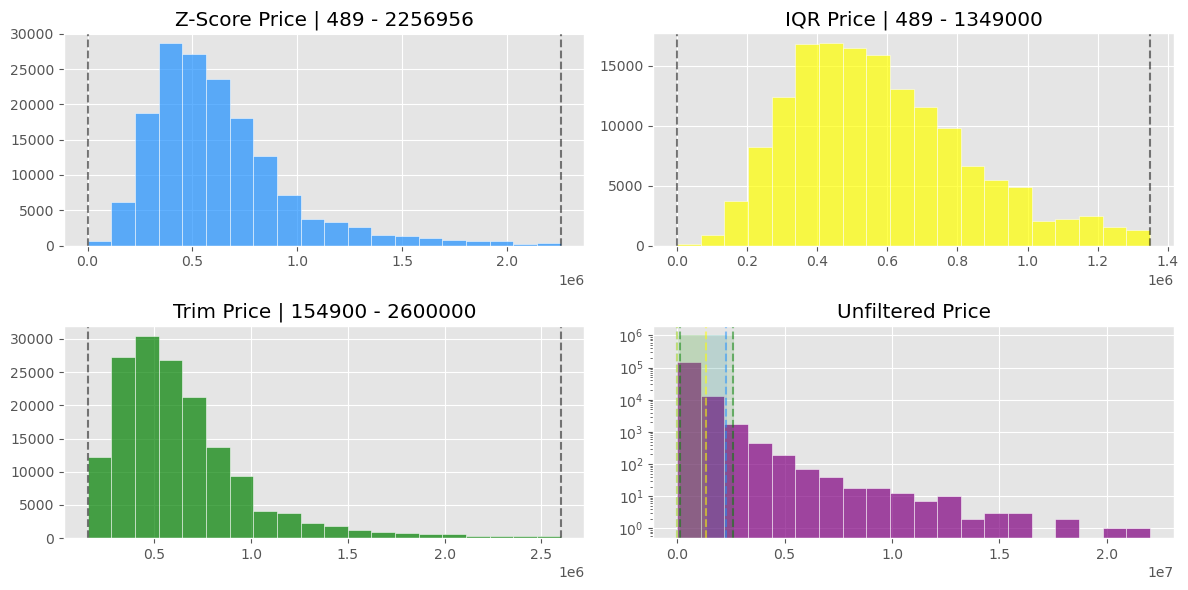

In [10]:
plot_outlier_methods(df, "price", iscont=True)
plt.show()

<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Outliers - Area</strong>
</div>

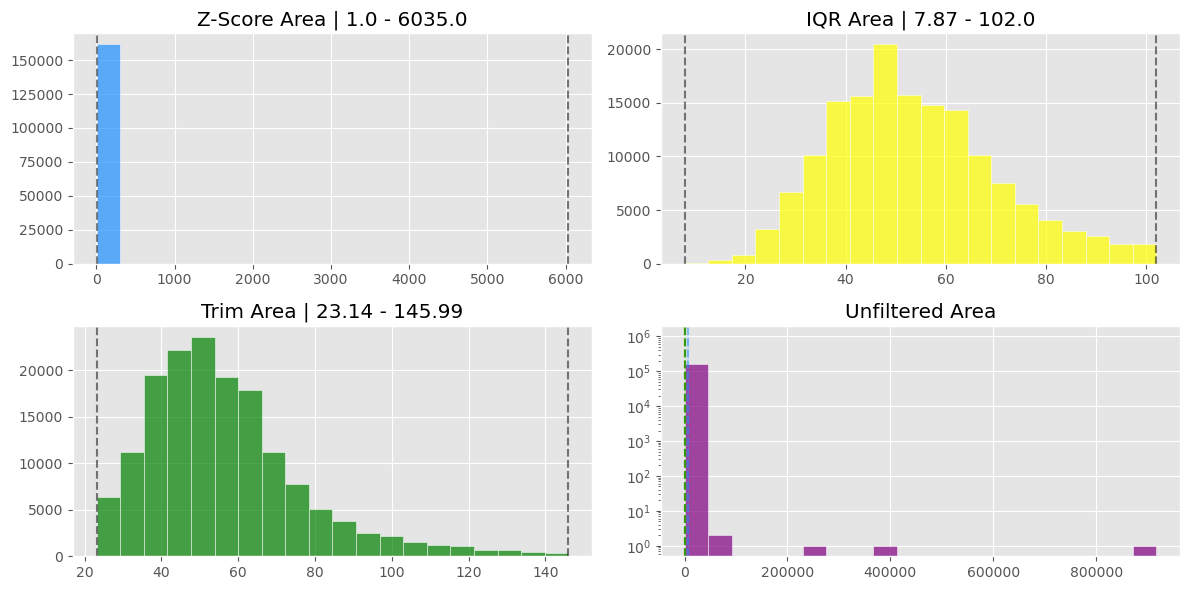

In [11]:
plot_outlier_methods(df, "area", iscont=True)
plt.show()

<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Outliers - Floor Total Number</strong>
</div>

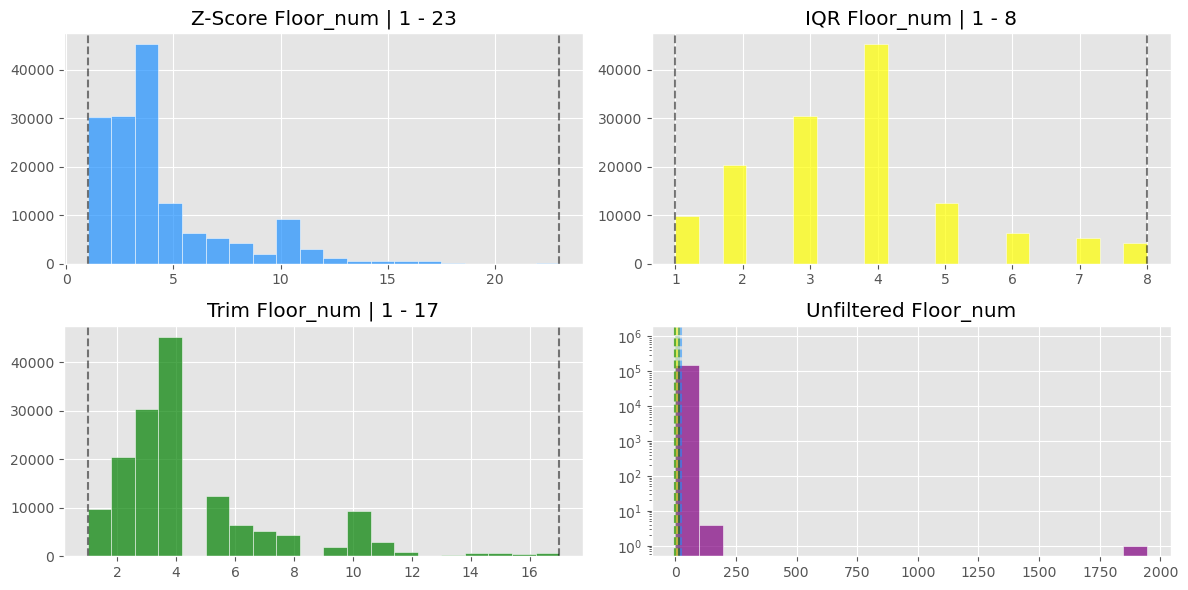

In [12]:
plot_outlier_methods(df, "floor_num")
plt.show()

<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Outliers - Build Year</strong>
</div>

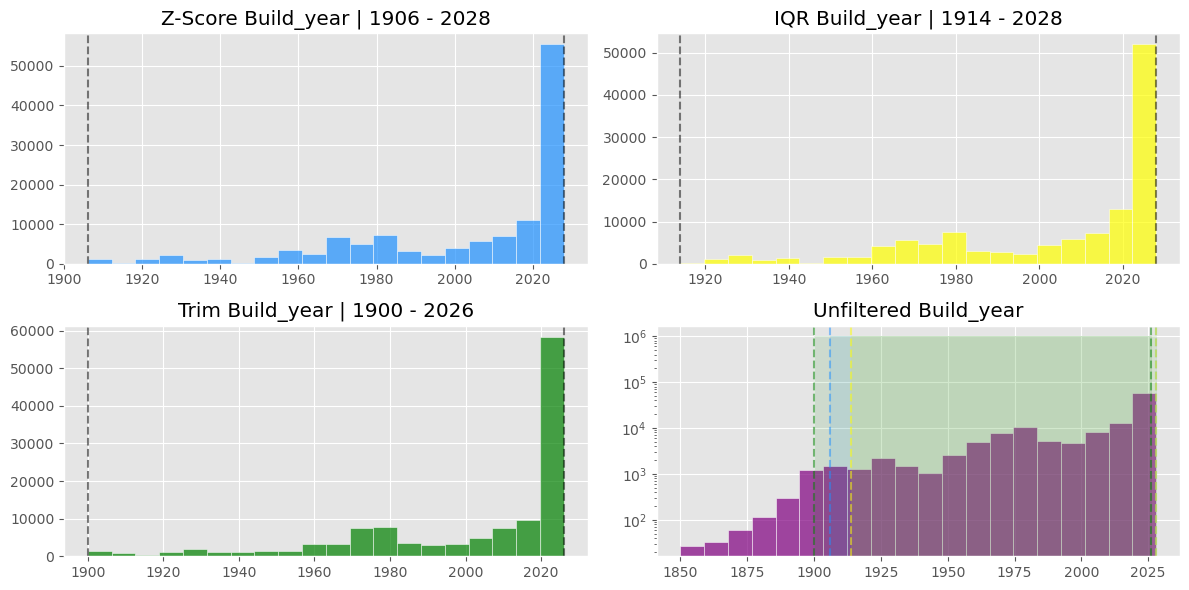

In [13]:
plot_outlier_methods(df, "build_year", bounds=(1850, 2030))
plt.show()

<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Outliers - Build Year</strong>
</div>

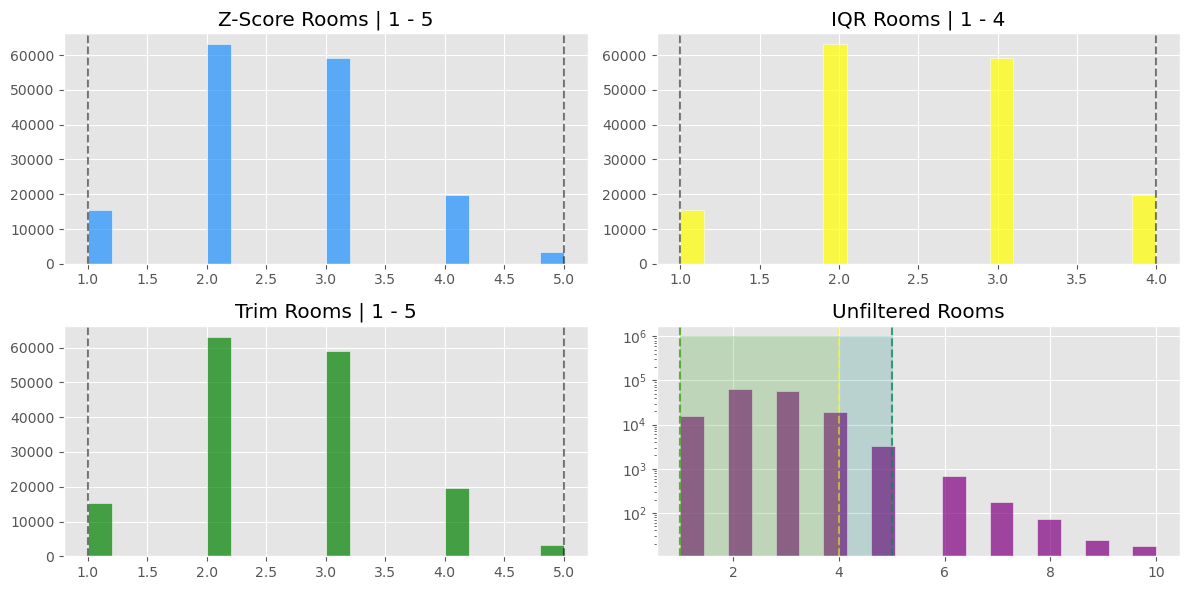

In [9]:
plot_outlier_methods(df, "rooms")
plt.show()

<div style="
    border-radius: 8px;
    box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
    background-color: #f4f4fc;
    padding: 15px;
    margin: 10px 0;
    font-family: 'Roboto', sans-serif;
    font-size: 18px;
    color: #333;
    border-left: 5px solid #5b9bd5;">

<strong>🎯 Pipeline definition</strong>
</div>

In [33]:
import geopandas as gpd

class FilterOutliers:

    def __init__(self, df: pd.DataFrame) -> None:
        self.df = df

    def floor_num(self):
        f_arg = (self.df["floor_num"].between(1, 17)) | (self.df["floor_num"].isna())
        num_deleted = len(np.where(f_arg == False)[0])
        self.df = self.df[f_arg]
        print("floor_num: ", num_deleted)
        return self

    def price(self):
        f_arg = self.df["price"].between(154_000, 3_000_000)
        num_deleted = len(np.where(f_arg == False)[0])
        self.df = self.df[f_arg]
        print("price: ", num_deleted)
        return self

    def area(self):
        f_arg = self.df["area"].between(23, 150)
        num_deleted = len(np.where(f_arg == False)[0])
        self.df = self.df[f_arg]
        print("area: ", num_deleted)
        return self

    def build_year(self):
        f_arg = (self.df["build_year"].between(1900, 2028)) | (self.df["build_year"].isna())
        num_deleted = len(np.where(f_arg == False)[0])
        self.df = self.df[f_arg]
        print("build_year: ", num_deleted)
        return self
    
    def rooms(self):
        f_arg = (self.df["rooms"].between(1, 5)) | (self.df["rooms"].isna())
        num_deleted = len(np.where(f_arg == False)[0])
        self.df = self.df[f_arg]
        print("rooms: ", num_deleted)
        return self
    
    def poland_bounds(self):
        BOUNDS = [("longitude", 14.122222, 24.145889), ("latitude", 49.002046, 54.905476)]
        for col, min_val, max_val in BOUNDS:
            f_arg = self.df[col].between(min_val, max_val)
            num_deleted = len(np.where(f_arg == False)[0])
            self.df = self.df[f_arg]
            print(f"{col}: {num_deleted}")
        return self
        

    def run(self) -> pd.DataFrame:
        return (
            self.floor_num()
            .price()
            .area()
            .build_year()
            .rooms()
            .poland_bounds()
            .df
        )

In [34]:
pipeline_outliers = FilterOutliers(df)
dff = pipeline_outliers.run()

floor_num:  1264
price:  2558
area:  2214
build_year:  997
rooms:  572
longitude: 57
latitude: 1


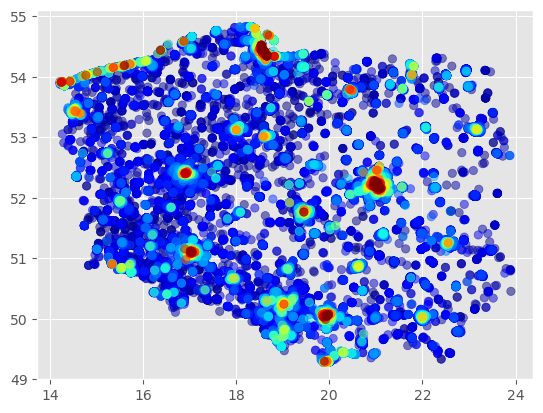

In [ ]:
dff = dff.sort_values(by="price", ascending=True)
plt.scatter(dff["longitude"], dff["latitude"], alpha=0.5, c=dff["price"], cmap="jet")
plt.show()